In [ ]:
import numpy as np
import pandas as pd
pd.options.display.max_colwidth = 100
from zlib import adler32
import requests

import numpy as np
import tensorflow as tf
import inspect
np.set_printoptions(suppress=True)

In [ ]:
url = 'https://raw.githubusercontent.com/adecate/Deep-Generative-models-VaR/main/Data/commodities_dataset.csv'
open('commodities_dataset.csv', 'wb').write(requests.get(url).content)
commodities = pd.read_csv('commodities_dataset.csv')


url = 'https://raw.githubusercontent.com/adecate/Deep-Generative-models-VaR/main/Data/stocks_dataset.csv'
open('stocks_dataset.csv', 'wb').write(requests.get(url).content);
stocks = pd.read_csv('stocks_dataset.csv')

In [ ]:
weights = np.ones([15,1]) * 1/15

stocks['Date'] =  pd.to_datetime(stocks['Date'])
stocks['year'] = stocks['Date'].dt.year

stocks = stocks.set_index('Date')
stocks = stocks[stocks['year'] >= 2021]
stocks = stocks.drop(columns=['year'])
stocks_change =stocks.pct_change()
ret_data = stocks_change[1:].dot(weights)

mean = ret_data.apply(func=np.mean, axis=0)
std = ret_data.apply(func=np.std, axis=0)

In [ ]:
commodities['Date'] =  pd.to_datetime(commodities['Date'])
commodities['year'] = commodities['Date'].dt.year

commodities = commodities.set_index('Date')
commodities = commodities[commodities['year'] >= 2021]
commodities = commodities.drop(columns=['year'])

com_returns = commodities.pct_change().dropna()
com_returns = com_returns[com_returns.index>='2021-01-01']

ret_data_com = com_returns[1:].dot(weights)

mean = ret_data_com.apply(func=np.mean, axis=0)
std = ret_data_com.apply(func=np.std, axis=0)

In [ ]:
gpu_devices = tf.config.list_physical_devices(device_type="GPU")
tf.config.experimental.set_memory_growth(device=gpu_devices[0], enable=True)
tf.keras.backend.set_floatx(value="float64")
tf.config.run_functions_eagerly(run_eagerly=True)

from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.stats import norm

import matplotlib.pyplot as plt

%matplotlib inline
from PIL import Image
import plotnine

# print("TensorFlow version:", tf.__version__)
# print("GPU:", gpu_devices)

In [ ]:
class BidirectionalGenerativeAdversarialNetworkDiscriminator(tf.keras.Model):
    def __init__(self, num_hidden):
        super().__init__()

        args, _, _, values = inspect.getargvalues(frame=inspect.currentframe())
        values.pop("self")

        for arg, val in values.items():
            setattr(self, arg, val)

        self.concat = tf.keras.layers.Concatenate(axis=-1)
        self.feature_extractor = tf.keras.Sequential(
            layers=[
                tf.keras.layers.Dense(
                    units=self.num_hidden,
                    activation=tf.keras.layers.LeakyReLU(alpha=0.2),
                ),
            ]
        )
        self.dropout = tf.keras.layers.Dropout(rate=0.5)
        self.discriminator = tf.keras.layers.Dense(
            units=1,
            activation="sigmoid",
        )

    def call(self, x, z):
        features = self.concat([x, z])
        features = self.feature_extractor(features)
        features = self.dropout(features)

        return self.discriminator(features)

In [ ]:
class BidirectionalGenerativeAdversarialNetworkGenerator(tf.keras.Model):
    def __init__(self, num_hidden, num_inputs):
        super().__init__()

        args, _, _, values = inspect.getargvalues(frame=inspect.currentframe())
        values.pop("self")

        for arg, val in values.items():
            setattr(self, arg, val)

        self.generator = tf.keras.Sequential(
            layers=[
                tf.keras.layers.Dense(
                    units=self.num_hidden,
                    activation="elu",
                ),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dense(
                    units=self.num_hidden,
                    activation="elu",
                ),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dense(
                    units=self.num_inputs,
                    activation="linear",
                ),
            ]
        )

    def call(self, z):
        return self.generator(z)

In [ ]:
class BidirectionalGenerativeAdversarialNetworkEncoder(tf.keras.Model):
    def __init__(self, num_hidden, num_encoding):
        super().__init__()

        args, _, _, values = inspect.getargvalues(frame=inspect.currentframe())
        values.pop("self")

        for arg, val in values.items():
            setattr(self, arg, val)

        self.encoder = tf.keras.Sequential(
            layers=[
                tf.keras.layers.Dense(
                    units=self.num_hidden,
                    activation=tf.keras.layers.LeakyReLU(alpha=0.2),
                ),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dense(
                    units=self.num_hidden,
                    activation=tf.keras.layers.LeakyReLU(alpha=0.2),
                ),
                tf.keras.layers.Dense(
                    units=self.num_encoding,
                    activation="tanh",
                ),
            ]
        )

    def call(self, x):
        return self.encoder(x)

In [ ]:
@tf.function
def train_step(x, real, z, fake):
    with tf.GradientTape() as dis_tape, tf.GradientTape(
        persistent=True
    ) as enc_gen_tape:
        enc = encoder(x=x, training=True)
        gen = generator(z=z, training=True)
        disc_loss_real = reconstruction_loss(
            y_true=real,
            y_pred=discriminator(
                x=x,
                z=enc,
                training=True,
            ),
        )
        disc_loss_fake = reconstruction_loss(
            y_true=fake,
            y_pred=discriminator(
                x=gen,
                z=z,
                training=True,
            ),
        )
        disc_loss = 0.5 * (disc_loss_real + disc_loss_fake)
        enc = encoder(x=x, training=True)
        gen = generator(z=z, training=True)
        enc_loss = reconstruction_loss(
            y_true=fake,
            y_pred=discriminator(
                x=x,
                z=enc,
                training=True,
            ),
        )
        gen_loss = reconstruction_loss(
            y_true=real,
            y_pred=discriminator(
                x=gen,
                z=z,
                training=True,
            ),
        )
    gradients_disc = dis_tape.gradient(
        target=disc_loss,
        sources=discriminator.trainable_variables,
    )
    optimizer_disc.apply_gradients(
        grads_and_vars=zip(
            gradients_disc,
            discriminator.trainable_variables,
        )
    )
    disc_loss_metric(disc_loss)
    gradients_enc = enc_gen_tape.gradient(
        target=enc_loss, sources=encoder.trainable_variables
    )
    optimizer_enc_gen.apply_gradients(
        grads_and_vars=zip(
            gradients_enc,
            encoder.trainable_variables,
        )
    )
    enc_loss_metric(enc_loss)
    gradients_gen = enc_gen_tape.gradient(
        target=gen_loss, sources=generator.trainable_variables
    )
    optimizer_enc_gen.apply_gradients(
        grads_and_vars=zip(
            gradients_gen,
            generator.trainable_variables,
        )
    )
    gen_loss_metric(gen_loss)

In [ ]:
def bigan_var(ret_data):
    num_inputs = ret_data.shape[1]
    num_hidden = 100
    num_encoding = 10
    num_epochs = 100
    batch_size = 100

    generator = BidirectionalGenerativeAdversarialNetworkGenerator(
        num_hidden=num_hidden, num_inputs=num_inputs
    )
    discriminator = BidirectionalGenerativeAdversarialNetworkDiscriminator(
        num_hidden=num_hidden
    )
    encoder = BidirectionalGenerativeAdversarialNetworkEncoder(
        num_hidden=num_hidden, num_encoding=num_encoding
    )

    ds = (
        tf.data.Dataset.from_tensor_slices(tensors=ret_data)
        .shuffle(buffer_size=ret_data.shape[0] * 2, reshuffle_each_iteration=True)
        .batch(batch_size=batch_size, drop_remainder=False)
    )

    reconstruction_loss = tf.keras.losses.BinaryCrossentropy(
        from_logits=False, reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE
    )
    optimizer_disc = tf.keras.optimizers.legacy.RMSprop(
        learning_rate=2e-4, decay=1e-8, clipvalue=1.0
    )
    optimizer_enc_gen = tf.keras.optimizers.legacy.RMSprop(
        learning_rate=4e-4, decay=1e-8, clipvalue=1.0
    )
    disc_loss_metric = tf.keras.metrics.Mean(name="train_disc_loss")
    enc_loss_metric = tf.keras.metrics.Mean(name="train_enc_loss")
    gen_loss_metric = tf.keras.metrics.Mean(name="train_gen_loss")


    for epoch in range(num_epochs):
        disc_loss_metric.reset_states()
        enc_loss_metric.reset_states()
        gen_loss_metric.reset_states()

        for x in ds:
            train_step(
                x=x,
                real=np.ones(shape=(x.shape[0], 1)),
                z=np.random.uniform(low=-1.0, high=1.0, size=(x.shape[0], num_encoding)),
                fake=np.zeros(shape=(x.shape[0], 1)),
            )

        if ((epoch + 1) % 100) == 0:
            print("Epoch:", epoch + 1)
            print("Discriminator loss:", disc_loss_metric.result())
            print("Encoder loss:", enc_loss_metric.result())
            print("Generator loss:", gen_loss_metric.result())


    num_sim = ret_data.shape[0]
    with tf.device(device_name="/CPU:0"):
        x_mean = [
            np.average(
                a=(
                    generator(
                        z=np.array(
                            object=[
                                np.random.uniform(low=ret_data.min(), high=ret_data.max(), size=(num_encoding))
                            ]
                        )
                    )[0]
                )
            )
            for i in range(num_sim)
        ]

    return np.percentile(a=x_mean, axis=0, q=1)

In [ ]:
from scipy.stats import chi2
def pof_test(var, target, alpha=0.998):
    exception = target < var
    t = len(target)
    m = exception.sum()
    nom = (1 - alpha)**m * alpha**(t-m)
    den = (1 - m/t)**(t - m) * (m / t)**m
    pof_test = -2 * np.log(nom / den)
    pvalue = 1 - chi2.cdf(pof_test, df=1)
    return pvalue

def if_test(var, target):
    exception = target < var
    pairs = [(exception[i], exception[i+1]) for i in range(len(exception) - 1)]
    pairs = np.array(pairs).astype('int')
    n00 = ((pairs[:, 0] == 0) & (pairs[:, 1] == 0)).sum()
    n01 = ((pairs[:, 0] == 0) & (pairs[:, 1] == 1)).sum()
    n10 = ((pairs[:, 0] == 1) & (pairs[:, 1] == 0)).sum()
    n11 = ((pairs[:, 0] == 1) & (pairs[:, 1] == 1)).sum()
    pi = (n01 + n11) / (n00 + n01 + n10 + n11)
    pi0 = n01 / (n00 + n01)
    pi1 = n11 / (n10 + n11)
    nom = (1 - pi)**(n00 + n10) * pi**(n01 + n11)
    den = (1 - pi0)**n00 * pi0**n01 * (1 - pi1)**n10 * pi1**n11
    if_test = -2 * np.log(nom / den)
    pvalue = 1 - chi2.cdf(if_test, df=1)
    return pvalue

def tests(df):
    print("%.2f" % pof_test(df['VaR'], df['Change']))
    print("%.2f" % if_test(df['VaR'], df['Change']))

# Commodities

In [ ]:
w = 200

i = w
portf = ret_data_com.copy()
var_values_gen = pd.DataFrame({'Date': [], 'VaR': []})

while i <=ret_data_com.shape[0] - 1:
  print(i)
  var_values_gen = pd.concat([var_values_gen, pd.DataFrame({'Date': [portf[i:i+1].index.date[0]], 'VaR': [bigan_var(portf[i-w:i])]})])
  i+=1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
var_values_gen.to_csv('var_values_gen.csv')

In [ ]:
from google.colab import files
files.download('var_values_gen.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

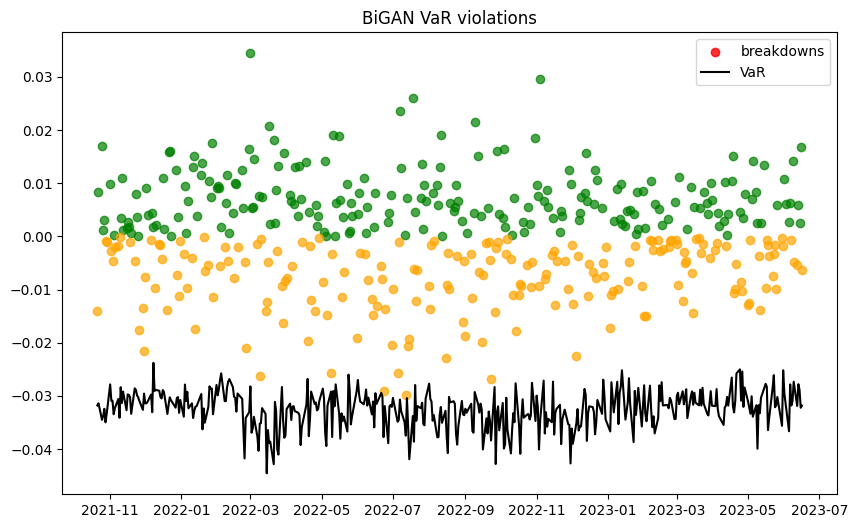

In [ ]:
var_values_gen_st = pd.read_csv('/content/drive/MyDrive/homeworks/DeepVaR/var_values_gen.csv')
var_values_gen_st = var_values_gen_st.drop(columns=['Unnamed: 0'])
portf= ret_data_com[200:]
fig, ax = plt.subplots(figsize=(10, 6))
pos = portf[portf.apply(lambda x: x >= 0)]
neg = portf[portf.apply(lambda x: x <  0)]

var_values['Date'] = pd.to_datetime(var_values['Date'])
var_df_com = var_values.merge(portf.reset_index(), on='Date')
var_df_com.columns = ['Date', 'VaR', 'Change']
var_df_com['VaR'] = var_df_com['VaR']
var_df_com['Violation'] = (var_df_com['Change'] < var_df_com['VaR'])
breakdowns = var_df_com[var_df_com['Violation'] == 1]

plt.scatter(pos.index,pos, c = 'green', alpha = 0.7)
plt.scatter(neg.index,neg, c = 'orange', alpha = 0.7)
plt.scatter(breakdowns.Date, breakdowns.Change, c = 'red', alpha = 0.8,  label = 'breakdowns')
plt.plot(var_df_com.Date, var_df_com.VaR, label = 'VaR', c = 'black')
plt.legend()
plt.title("{} VaR violations".format('BiGAN'))
plt.show();

In [ ]:
tests(var_df_com)

0.20
1.00


<ipython-input-28-2eebef31b1a0>:22: RuntimeWarning: invalid value encountered in long_scalars


#Stocks

In [ ]:
w = 200

i = w
portf = ret_data.copy()
var_values_gen_st = pd.DataFrame({'Date': [], 'VaR': []})

while i <=ret_data.shape[0] - 1:
  print(i)
  var_values_gen_st = pd.concat([var_values_gen_st, pd.DataFrame({'Date': [portf[i:i+1].index.date[0]], 'VaR': [bigan_var(portf[i-w:i])]})])
  i+=1

In [ ]:
var_values_gen_st.to_csv('var_values_gen_st.csv')

In [ ]:
files.download('var_values_gen_st.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

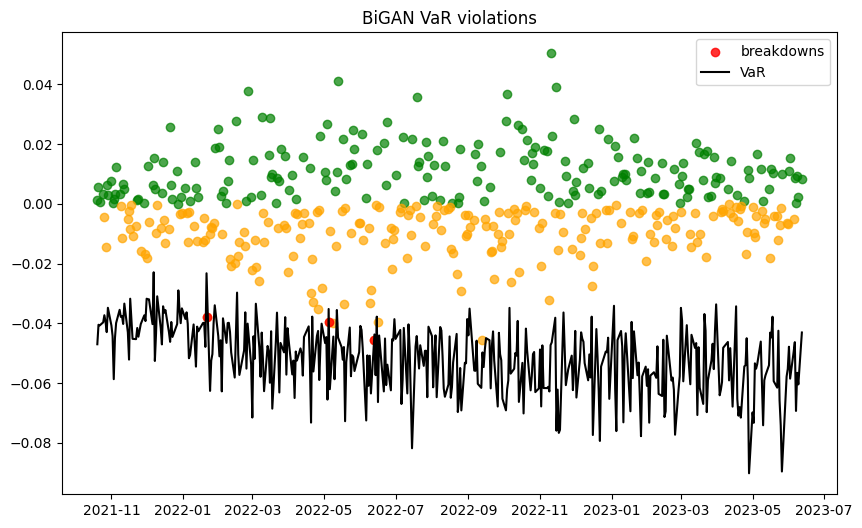

In [ ]:
var_values_gen_st = pd.read_csv('/content/drive/MyDrive/homeworks/DeepVaR/var_values_gen_st.csv')
var_values_gen_st = var_values_gen_st.drop(columns=['Unnamed: 0'])
portf= ret_data[200:]
fig, ax = plt.subplots(figsize=(10, 6))
pos = portf[portf.apply(lambda x: x >= 0)]
neg = portf[portf.apply(lambda x: x <  0)]

var_values_gen_st['Date'] = pd.to_datetime(var_values_gen_st['Date'])

var_df_gen_st = var_values_gen_st.merge(portf.reset_index(), on='Date')
var_df_gen_st.columns = ['Date', 'VaR', 'Change']
var_df_gen_st['VaR'] = var_df_gen_st['VaR']
var_df_gen_st['VaR'] = var_df_gen_st['VaR'] - 0.015
var_df_gen_st['Violation'] = (var_df_gen_st['Change'] < var_df_gen_st['VaR'])
breakdowns = var_df_gen_st[var_df_gen_st['Violation'] == 1]


plt.scatter(pos.index,pos, c = 'green', alpha = 0.7)
plt.scatter(neg.index,neg, c = 'orange', alpha = 0.7)
plt.scatter(breakdowns.Date, breakdowns.Change, c = 'red', alpha = 0.8,  label = 'breakdowns')
plt.plot(var_df_gen_st.Date, var_df_gen_st.VaR, label = 'VaR', c = 'black')
plt.legend()
plt.title("{} VaR violations".format('BiGAN'))
plt.show();

In [ ]:
tests(var_df_gen_st)

0.07
0.83


In [ ]:
tests(var_df_gen)

0.28
0.89
